In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install tensorflow --quiet

In [4]:
# Import libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Import libraries for working with dates and times
import datetime as dt

# Import TensorFlow and Keras libraries for building and training neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, Reshape, Flatten
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

# Import scikit-learn library for various metrics and preprocessing tools
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Import matplotlib library for creating plots and charts
import matplotlib.pyplot as plt

# Magic command to display plots inline in the Jupyter Notebook
%matplotlib inline

In [5]:
# Read in the Silver dataset from a CSV file
df=pd.read_csv("/content/drive/MyDrive/PTDLKD/Data/Silver_Data.csv")
df=df.set_index(pd.DatetimeIndex(df['Date'].values))


# Preprocessing Data

---

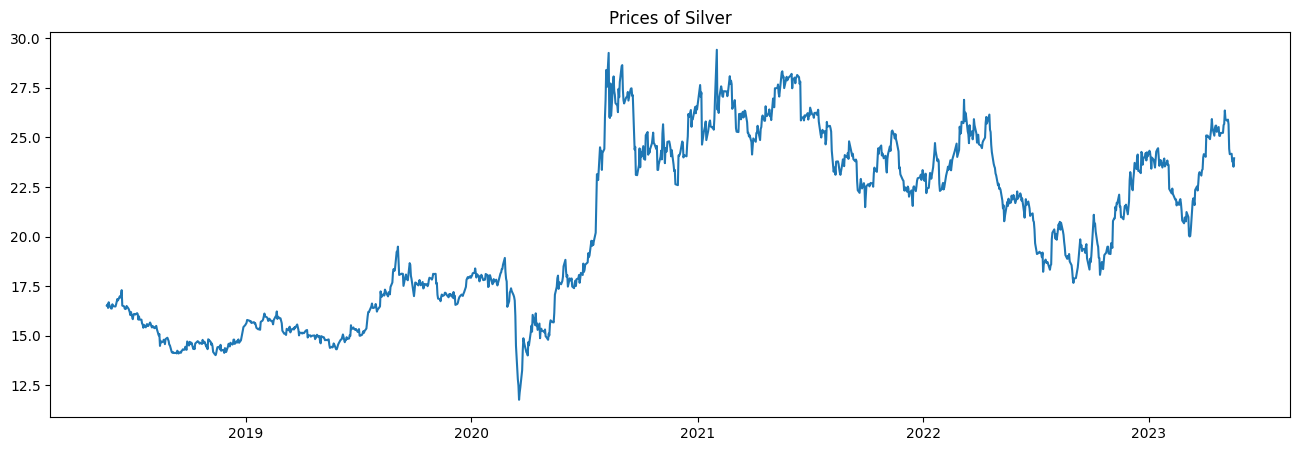

In [7]:
# Format column Date
df.index = pd.to_datetime(df.index,format='%m/%d/%Y')

# Flip the column
df = df.iloc[::-1]

# Create new Dataframe
df1 = pd.DataFrame(df, columns=['Date', 'Price'])
df1.drop('Date', axis = 1, inplace = True)

# Plot the 'price' column of the 'df' DataFrame
plt.figure(figsize=(16,5))
plt.plot(df1['Price'])
plt.title('Prices of Silver')
plt.show()

# Split dataset (7-2-1)

---



In [8]:
# Convert the 'df1' DataFrame to a NumPy array
data = df1.values

# Split the data (7-2-1)
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [9]:
# Create a MinMaxScaler object with a specified range
sc = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the data and transform the data
sc_train = sc.fit_transform(data)

In [10]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [11]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [12]:
model = Sequential()

model.add(SimpleRNN(50, input_shape=(5, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.compile(loss='mean_absolute_error', optimizer='adam')

save_model = 'save_model(7-2-1).hdf5'

best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80

Epoch 1: loss improved from inf to 0.18638, saving model to save_model(7-2-1).hdf5
18/18 - 5s - loss: 0.1864 - 5s/epoch - 256ms/step
Epoch 2/80

Epoch 2: loss improved from 0.18638 to 0.05561, saving model to save_model(7-2-1).hdf5
18/18 - 0s - loss: 0.0556 - 129ms/epoch - 7ms/step
Epoch 3/80

Epoch 3: loss improved from 0.05561 to 0.02849, saving model to save_model(7-2-1).hdf5
18/18 - 0s - loss: 0.0285 - 159ms/epoch - 9ms/step
Epoch 4/80

Epoch 4: loss improved from 0.02849 to 0.02516, saving model to save_model(7-2-1).hdf5
18/18 - 0s - loss: 0.0252 - 261ms/epoch - 14ms/step
Epoch 5/80

Epoch 5: loss improved from 0.02516 to 0.02450, saving model to save_model(7-2-1).hdf5
18/18 - 0s - loss: 0.0245 - 213ms/epoch - 12ms/step
Epoch 6/80

Epoch 6: loss improved from 0.02450 to 0.02259, saving model to save_model(7-2-1).hdf5
18/18 - 0s - loss: 0.0226 - 130ms/epoch - 7ms/step
Epoch 7/80

Epoch 7: loss did not improve from 0.02259
18/18 - 0s - loss: 0.0236 - 180ms/epoch - 10ms/s

In [13]:
# Transform the y_train array back to the original scale
y_train = sc.inverse_transform(y_train)

# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model(7-2-1).hdf5')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

28/28 [==============================] - 1s 5ms/step


In [14]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

8/8 [==============================] - 0s 9ms/step


In [15]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

4/4 [==============================] - 0s 3ms/step


In [16]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[sc_train.shape[0]-5:].reshape(1, -1)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        print(x_input.shape)
        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps,1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
[[0.6834309697151184], [0.6791232824325562], [0.6748499274253845], [0.6681748032569885], [0.664532482624054], [0.6603441834449768], [0.6563190221786499], [0.6524204015731812], [0.6482869386672974], [0.6442593336105347], [0.6402323842048645], [0.6362317204475403], [0.63227379322052], [0.6283280849456787], [0.6244064569473267], [0.6205030679702759], [0.61661696434021], [0.6127498149871826], [0.6088992953300476], [0.6050653457641602], [0.6012468934059143], [0.5974430441856384], [0.5936532616615295], [0.589876651763916], [0.5861124992370605], [0.5823602080345154], [0.5786190032958984], [0.5748883485794067], [0.5711672902107239], [0.5674554705619812]]


In [17]:
# Convert the 'date' column in the dataframe to a list of strings
datelist_train = df['Date'].astype(str).tolist()

# Parse the date strings using strptime(), using the correct format string
datelist_train = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in datelist_train]

# Generate a list of future dates, starting from the last date in the training data and going for 15 days
datelist_future = pd.date_range(datelist_train[-1], periods=30, freq='1d').tolist()

<Figure size 1600x500 with 0 Axes>

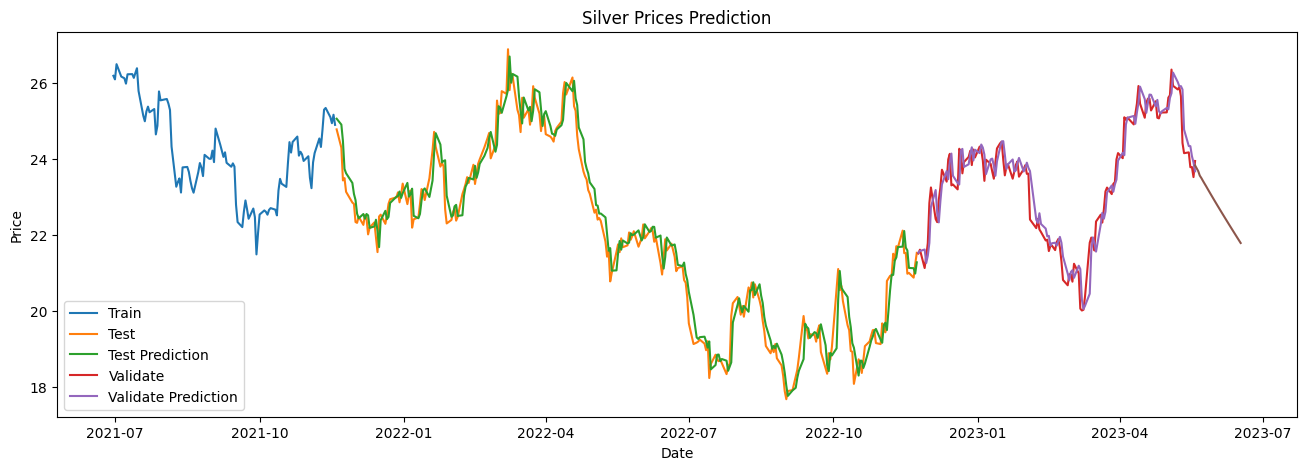

In [18]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.figure(figsize=(16,5))
plt.plot(train_data.index[train_size-100:], train_data.Price[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Silver Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [19]:
# Calculate the accuracy of each model
def evaluateModel(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [20]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  0.33565242922306066
MAPE:  1.5467042267751958
RMSE:  0.43644792515886044

** Validate **
MAE:  0.32066459167003625
MAPE:  1.381938516320987
RMSE:  0.4230462540701585


# Split dataset (6-3-1)

---



In [21]:
# Split data (6-3-1)
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [22]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [23]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [24]:
model = Sequential()

model.add(SimpleRNN(50, input_shape=(5, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.compile(loss='mean_absolute_error', optimizer='adam')

save_model = 'save_model(6-3-1).hdf5'

best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80

Epoch 1: loss improved from inf to 0.30979, saving model to save_model(6-3-1).hdf5
16/16 - 1s - loss: 0.3098 - 1s/epoch - 92ms/step
Epoch 2/80

Epoch 2: loss improved from 0.30979 to 0.08467, saving model to save_model(6-3-1).hdf5
16/16 - 0s - loss: 0.0847 - 66ms/epoch - 4ms/step
Epoch 3/80

Epoch 3: loss improved from 0.08467 to 0.04458, saving model to save_model(6-3-1).hdf5
16/16 - 0s - loss: 0.0446 - 64ms/epoch - 4ms/step
Epoch 4/80

Epoch 4: loss improved from 0.04458 to 0.03181, saving model to save_model(6-3-1).hdf5
16/16 - 0s - loss: 0.0318 - 65ms/epoch - 4ms/step
Epoch 5/80

Epoch 5: loss improved from 0.03181 to 0.02930, saving model to save_model(6-3-1).hdf5
16/16 - 0s - loss: 0.0293 - 68ms/epoch - 4ms/step
Epoch 6/80

Epoch 6: loss improved from 0.02930 to 0.02827, saving model to save_model(6-3-1).hdf5
16/16 - 0s - loss: 0.0283 - 70ms/epoch - 4ms/step
Epoch 7/80

Epoch 7: loss improved from 0.02827 to 0.02542, saving model to save_model(6-3-1).hdf5
16/16 - 0s -

In [25]:
# Transform the y_train array back to the original scale
y_train = sc.inverse_transform(y_train)

# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model(6-3-1).hdf5')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

24/24 [==============================] - 0s 2ms/step


In [26]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

12/12 [==============================] - 0s 2ms/step


In [27]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

4/4 [==============================] - 0s 4ms/step


In [28]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[sc_train.shape[0]-5:].reshape(1, -1)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps,1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.6873371005058289], [0.6873607635498047], [0.6859513521194458], [0.682435929775238], [0.6819554567337036], [0.6808443665504456], [0.6801429390907288], [0.679411768913269], [0.6784207820892334], [0.6775251030921936], [0.6765901446342468], [0.6756985783576965], [0.6748378872871399], [0.6739805936813354], [0.6731392741203308], [0.6723038554191589], [0.6714789867401123], [0.6706655621528625], [0.669862687587738], [0.6690709590911865], [0.6682893633842468], [0.6675179600715637], [0.6667565107345581], [0.6660048365592957], [0.6652626991271973], [0.6645299792289734], [0.6638066172599792], [0.6630924940109253], [0.6623873710632324], [0.6616911888122559]]


<Figure size 1600x500 with 0 Axes>

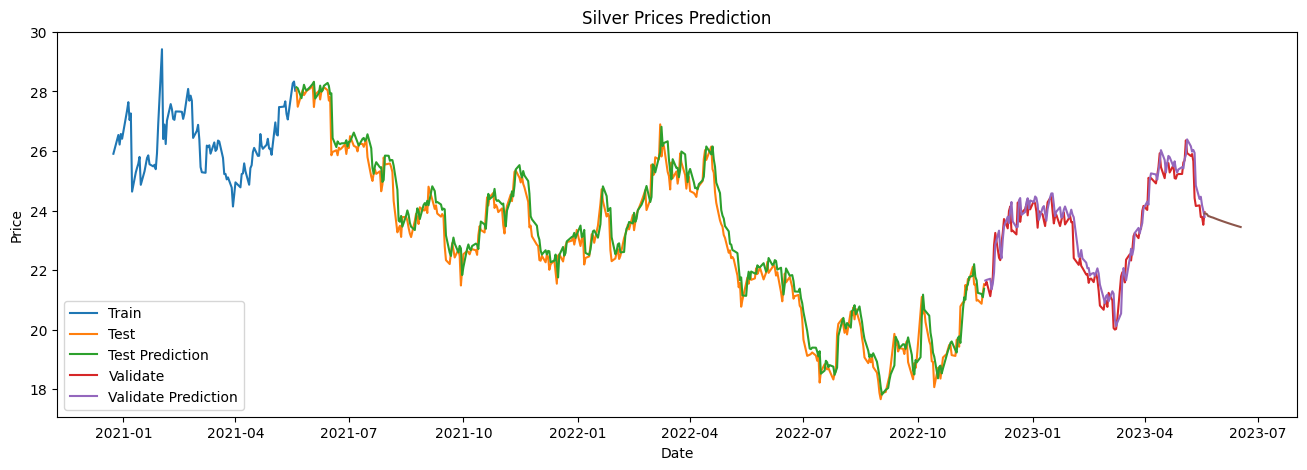

In [29]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.figure(figsize=(16,5))
plt.plot(train_data.index[train_size-100:], train_data.Price[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Silver Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [30]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  0.35209122439225515
MAPE:  1.567855073488969
RMSE:  0.4627694610449683

** Validate **
MAE:  0.34291430652141563
MAPE:  1.4807999413849497
RMSE:  0.44845057818480416


# Split dataset (5-3-2)

---



In [31]:
# Split data (5-3-2)
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [32]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [33]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [34]:
model = Sequential()

model.add(SimpleRNN(50, input_shape=(5, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.compile(loss='mean_absolute_error', optimizer='adam')

save_model = 'save_model(5-3-2).hdf5'

best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80

Epoch 1: loss improved from inf to 0.05958, saving model to save_model(5-3-2).hdf5
13/13 - 1s - loss: 0.0596 - 1s/epoch - 92ms/step
Epoch 2/80

Epoch 2: loss improved from 0.05958 to 0.03203, saving model to save_model(5-3-2).hdf5
13/13 - 0s - loss: 0.0320 - 55ms/epoch - 4ms/step
Epoch 3/80

Epoch 3: loss improved from 0.03203 to 0.02668, saving model to save_model(5-3-2).hdf5
13/13 - 0s - loss: 0.0267 - 58ms/epoch - 4ms/step
Epoch 4/80

Epoch 4: loss improved from 0.02668 to 0.02406, saving model to save_model(5-3-2).hdf5
13/13 - 0s - loss: 0.0241 - 72ms/epoch - 6ms/step
Epoch 5/80

Epoch 5: loss improved from 0.02406 to 0.02238, saving model to save_model(5-3-2).hdf5
13/13 - 0s - loss: 0.0224 - 59ms/epoch - 5ms/step
Epoch 6/80

Epoch 6: loss improved from 0.02238 to 0.02170, saving model to save_model(5-3-2).hdf5
13/13 - 0s - loss: 0.0217 - 62ms/epoch - 5ms/step
Epoch 7/80

Epoch 7: loss improved from 0.02170 to 0.02061, saving model to save_model(5-3-2).hdf5
13/13 - 0s -

In [35]:
# Transform the y_train array back to the original scale
y_train = sc.inverse_transform(y_train)

# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model(5-3-2).hdf5')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

20/20 [==============================] - 0s 3ms/step


In [36]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

12/12 [==============================] - 0s 3ms/step


In [37]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

8/8 [==============================] - 0s 3ms/step


In [38]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[sc_train.shape[0]-5:].reshape(1, -1)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps,1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.6880585551261902], [0.6903893351554871], [0.6903781890869141], [0.6883195638656616], [0.6889680624008179], [0.688783586025238], [0.6891982555389404], [0.6895387172698975], [0.6896777153015137], [0.689896285533905], [0.6900333166122437], [0.6902034878730774], [0.6903790235519409], [0.6905488967895508], [0.6907238960266113], [0.6908919811248779], [0.6910584568977356], [0.6912230253219604], [0.6913852691650391], [0.6915463209152222], [0.6917055249214172], [0.6918630003929138], [0.6920186877250671], [0.6921725273132324], [0.6923245191574097], [0.6924747228622437], [0.6926233172416687], [0.6927706599235535], [0.6929160356521606], [0.693060040473938]]


<Figure size 1600x500 with 0 Axes>

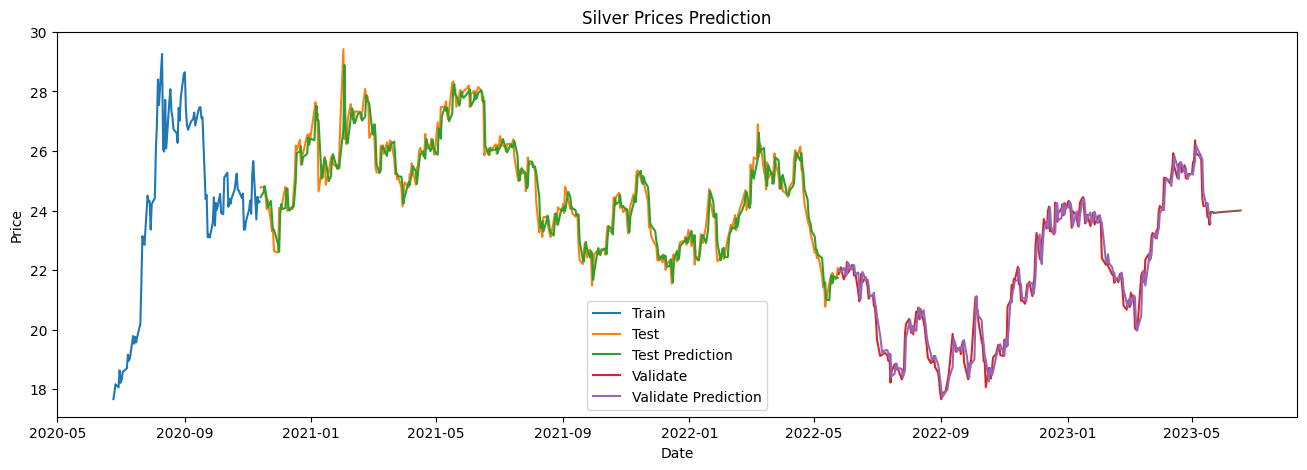

In [39]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.figure(figsize=(16,5))
plt.plot(train_data.index[train_size-100:], train_data.Price[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Silver Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [40]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  0.3431047244469325
MAPE:  1.3845488845121319
RMSE:  0.4853487123704728

** Validate **
MAE:  0.3153700169920921
MAPE:  1.4700968109823398
RMSE:  0.415859640568736


# Evaluate Model

---